## Data Set Information: 
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to t he same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.  
Use the ‘bank-additional-full.csv’ from the bank-additional.zip file with all examples (41 188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to th e data analyzed in [Moro et al., 2014] 
Data source: https://archive.ics.uci.edu/ml/machine-learning-databases/00222/ 
The classification goal is to predict if the client will subscribe (yes/no) a term deposit (var iable y).

 

## Problem Statement: 
The classification goal is to predict if the client will subscribe a term deposit using KNN classification algorithm. You can use PCA technique as a dimension reduction measure. Its application has already been taught in the previous class

In [25]:
import pandas as pd
#read the csv file and store it in 'bank' dataframe
bank = pd.read_csv('bank-additional-full.csv',sep=';')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [26]:
# list all columns (for reference)
bank.columns
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [27]:
# convert the response to numeric values and store as a new column
bank['outcome'] = bank.y.map({'no':0, 'yes':1})

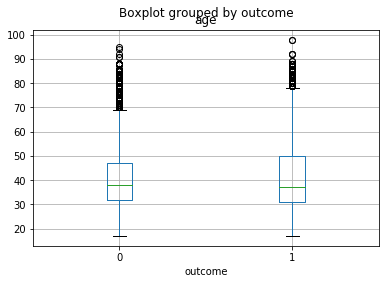

In [28]:
%matplotlib inline
# probably not a great feature since lot of outliers
bank.boxplot(column='age', by='outcome')

In [29]:
## useful features as all values revolve around same space
bank.groupby('job').outcome.mean()

job
admin.           0.129726
blue-collar      0.068943
entrepreneur     0.085165
housemaid        0.100000
management       0.112175
retired          0.252326
self-employed    0.104856
services         0.081381
student          0.314286
technician       0.108260
unemployed       0.142012
unknown          0.112121
Name: outcome, dtype: float64

In [30]:
# create job_dummies (we will add it to the bank DataFrame later)
job_dummies = pd.get_dummies(bank.job, prefix='job')
job_dummies.drop(job_dummies.columns[0], axis=1, inplace=True)

In [31]:
# looks like a useful feature
bank.groupby('default').outcome.mean()

default
no         0.12879
unknown    0.05153
yes        0.00000
Name: outcome, dtype: float64

In [32]:
# but only one person in the dataset has a status of yes
bank.default.value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [33]:
# so, let's treat this as a 2-class feature rather than a 3-class feature
bank['default'] = bank.default.map({'no':0, 'unknown':1, 'yes':1})
# convert the feature to numeric values
bank['contact'] = bank.contact.map({'cellular':0, 'telephone':1})

In [34]:
# looks like a useful feature at first glance
bank.groupby('month').outcome.mean()

month
apr    0.204787
aug    0.106021
dec    0.489011
jul    0.090466
jun    0.105115
mar    0.505495
may    0.064347
nov    0.101439
oct    0.438719
sep    0.449123
Name: outcome, dtype: float64

In [35]:
# but, it looks like their success rate is actually just correlated with number of calls
# thus, the month feature is unlikely to generalize
bank.groupby('month').outcome.agg(['count', 'mean']).sort_values('count')

,count,mean
month,,
dec,182,0.489011
mar,546,0.505495
sep,570,0.449123
oct,718,0.438719
apr,2632,0.204787
nov,4101,0.101439
jun,5318,0.105115
aug,6178,0.106021
jul,7174,0.090466


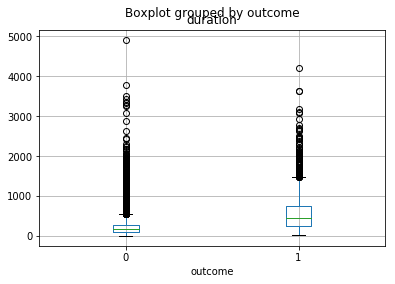

In [36]:
# looks like an excellent feature, but you can't know the duration of a call beforehand, thus it can't be used in your model
bank.boxplot(column='duration', by='outcome')

In [37]:
# looks like a useful feature
bank.groupby('previous').outcome.mean()

previous
0    0.088322
1    0.212015
2    0.464191
3    0.592593
4    0.542857
5    0.722222
6    0.600000
7    0.000000
Name: outcome, dtype: float64

In [38]:
# looks like a useful feature
bank.groupby('poutcome').outcome.mean()

poutcome
failure        0.142286
nonexistent    0.088322
success        0.651129
Name: outcome, dtype: float64

In [39]:
# create poutcome_dummies
poutcome_dummies = pd.get_dummies(bank.poutcome, prefix='poutcome')
poutcome_dummies.drop(poutcome_dummies.columns[0], axis=1, inplace=True)
# concatenate bank DataFrame with job_dummies and poutcome_dummies
bank = pd.concat([bank, job_dummies, poutcome_dummies], axis=1)

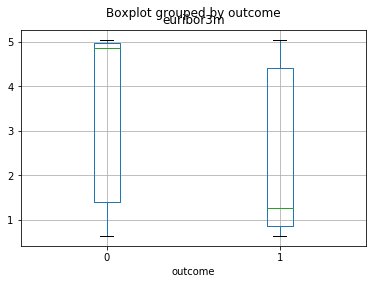

In [40]:
# prepare a boxplot on euribor3m by outcome, and comment on the 'euribor3m' feature
# looks like an excellent feature
bank.boxplot(column='euribor3m', by='outcome')

## Model Building

In [41]:
## create X dataframe having 'default', 'contact', 'previous', 'euribor3m' and including 13 dummy #columns
feature_cols = ['default', 'contact', 'previous', 'euribor3m'] + list(bank.columns[-13:])
X = bank[feature_cols]
# create y
y = bank.outcome
X.head()

,default,contact,previous,euribor3m,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,poutcome_nonexistent,poutcome_success
0,0,1,0,4.857,0,0,1,0,0,0,0,0,0,0,0,1,0
1,1,1,0,4.857,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,1,0,4.857,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,1,0,4.857,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,4.857,0,0,0,0,0,0,1,0,0,0,0,1,0


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

In [43]:
## Import the Classifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
## Instantiate the model with 5 neighbors.
model = KNeighborsClassifier(n_neighbors=5)
## Fit the model on the training data.
model.fit(X_train, y_train)
# use the model to make predictions with the test data
y_pred = model.predict(X_test)
# how did our model perform?
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 1401
Accuracy: 0.89
